# Proyecto 1

## 1. Carga de librerías

In [81]:
!pip install imbalanced-learn

In [296]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import string
import re

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Metricas
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nicolasortega/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Lectura de datos 

In [221]:
df = pd.read_csv('datos.csv',sep=';',header=None)
df.columns = ['mensaje','sentimiento']
# df["id"] = range(0,len(df["mensaje"]))
df

,mensaje,sentimiento
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


## Limpieza y Tokenizacion

El proceso de limpieza de texto, dentro del ámbito de text mining, consiste en eliminar del texto todo aquello que no aporte información sobre su temática, estructura o contenido. No existe una única forma de hacerlo, depende en gran medida de la finalidad del análisis y de la fuente de la que proceda el texto. Por ejemplo, en las redes sociales, los usuarios pueden escribir de la forma que quieran, lo que suele resultar en un uso elevado de abreviaturas y signos de puntuación. En este ejercicio, se procede a eliminar: patrones no informativos (urls de páginas web), signos de puntuación, etiquetas HTML, caracteres sueltos y números.

Tokenizar un texto consiste en dividir el texto en las unidades que lo conforman, entendiendo por unidad el elemento más sencillo con significado propio para el análisis en cuestión, en este caso, las palabras.

Existen múltiples librerías que automatizan en gran medida la limpieza y tokenización de texto, por ejemplo, la clase feature_extraction.text.CountVectorizer de Scikit Learn, nltk.tokenize o spaCy. A pesar de ello, para este ejemplo, se define una función que, si bien está menos optimizada, tiene la ventaja de poder adaptarse fácilmente dependiendo del tipo de texto analizado.

In [228]:
def limpiar_tokenizar(mensaje):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = mensaje.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    
    return(nuevo_texto)

test = "Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining"
print(test)
print(limpiar_tokenizar(mensaje=test))

Esto es 1 ejemplo de l'limpieza de6 TEXTO  https://t.co/rnHPgyhx4Z @cienciadedatos #textmining
['esto', 'es', 'ejemplo', 'de', 'limpieza', 'de', 'texto', 'cienciadedatos', 'textmining']


In [230]:
# Se aplica la función de limpieza y tokenización a cada mensaje
# ==============================================================================
df['mensaje_tokenizado'] = df['mensaje'].apply(lambda x: limpiar_tokenizar(x))
df[['mensaje', 'mensaje_tokenizado']].head()

,mensaje,mensaje_tokenizado
0,im feeling rather rotten so im not very ambiti...,"[im, feeling, rather, rotten, so, im, not, ver..."
1,im updating my blog because i feel shitty,"[im, updating, my, blog, because, feel, shitty]"
2,i never make her separate from me because i do...,"[never, make, her, separate, from, me, because..."
3,i left with my bouquet of red and yellow tulip...,"[left, with, my, bouquet, of, red, and, yellow..."
4,i was feeling a little vain when i did this one,"[was, feeling, little, vain, when, did, this, ..."


 ## Análisis exploratorio

A la hora de entender que caracteriza la escritura de cada autor, es interesante estudiar qué palabras emplea, con qué frecuencia, así como el significado de las mismas.

En Python, una de las estructuras que más facilita el análisis exploratorio es el DataFrame de Pandas, que es la estructura en la que se encuentra almacenada ahora la información de los tweets. Sin embargo, al realizar la tokenización, ha habido un cambio importante. Antes de dividir el texto, los elementos de estudio eran los tweets, y cada uno se encontraba en una fila, cumplimento así la condición de tidy data: una observación, una fila. Al realizar la tokenización, el elemento de estudio ha pasado a ser cada token (palabra), incumpliendo así la condición de tidy data. Para volver de nuevo a la estructura ideal se tiene que expandir cada lista de tokens, duplicando el valor de las otras columnas tantas veces como sea necesario. A este proceso se le conoce como expansión o unnest.

Aunque puede parecer un proceso poco eficiente (el número de filas aumenta mucho), este simple cambio facilita actividades de tipo: agrupación, contaje, gráficos...

In [231]:
# Unnest de la columna texto_tokenizado
# ==============================================================================
df_tidy = df.explode(column='mensaje_tokenizado')
df_tidy = df_tidy.drop(columns='mensaje')
df_tidy = df_tidy.rename(columns={'mensaje_tokenizado':'token'})
df_tidy.head(3)

,sentimiento,token
0,sadness,im
0,sadness,feeling
0,sadness,rather


## Palabras totales utilizadas

In [232]:
df_tidy['token'].count()

34073

## Palabras totales distintas

In [233]:
df_tidy['token'].nunique()

4778

## Palabras más utilizadas

In [307]:
 # df_tidy.groupby(['token'])["token"] \
 # .count() \
 # .reset_index(name='count') \
 # .apply(lambda x: x.sort_values('count', ascending=False).head(5))

## Stop words

En la tabla anterior puede observarse que los términos más frecuentes en todos los usuarios se corresponden con artículos, preposiciones, pronombres…, en general, palabras que no aportan información relevante sobre el texto. Ha estas palabras se les conoce como stopwords. Para cada idioma existen distintos listados de stopwords, además, dependiendo del contexto, puede ser necesario adaptar el listado. Por ejemplo, en la tabla anterior aparece el término amp que procede de la etiqueta html &amp. Con frecuencia, a medida que se realiza un análisis se encuentran palabras que deben incluirse en el listado de stopwords.

In [308]:
# Obtención de listado de stopwords del inglés
# ==============================================================================
stop_words = list(stopwords.words('english'))
# Se añade la stoprword: amp, ax, ex
stop_words.extend(("amp", "xa", "xe","im"))
print(stop_words[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [309]:
# Filtrado para excluir stopwords
# ==============================================================================
df_tidy = df_tidy[~(df_tidy["token"].isin(stop_words))]

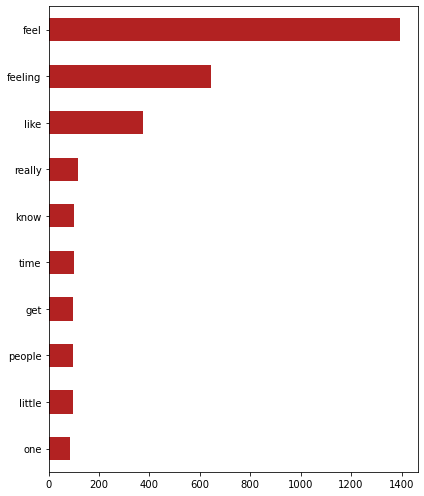

In [310]:
# Top 10 palabras (sin stopwords)
# ==============================================================================
fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(6, 7))
counts  = df_tidy['token'].value_counts(ascending=False).head(10)
counts.plot(kind='barh', color='firebrick')
axs.invert_yaxis()
fig.tight_layout()

## Clasificación de mensajes


Para poder aplicar algoritmos de clasificación a un texto, es necesario crear una representación numérica del mismo. Una de las formas más utilizadas se conoce como Bag of Words. Este método consiste en identificar el set formado por todas las palabras (tokens) que aparecen en el corpus, en este caso el conjunto de todos los tweets recuperados. Con este set se crea un espacio n-dimensional en el que cada dimensión (columna) es una palabra. Por último, se proyecta cada texto en ese espacio, asignando un valor para cada dimensión. En la mayoría de casos, el valor utilizado es el tf-idf.

En el siguiente apartado se construye un modelo de aprendizaje estadístico basado en máquinas de vector soporte (SVM) con el objetivo de predecir la autoría de los tweets. En concreto, se comparan los tweets de Elon Musk y Mayor Ed Lee.

Como modelo se emplea un SVM de Scikit-Learn. Para facilitar la obtención de la matriz TF-IDF se recurre a la clase TfidVectorized también de Scikit-Learn pero, en lugar de utilizar el tokenizador por defecto, se emplea el mismo definido en los apartados anteriores.


In [311]:
X = df['mensaje']
y = df['sentimiento']

In [312]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.3,
                                        random_state = 123
                                    )

## Vectorización tf-idf

In [313]:
# Creación de la matriz tf-idf
# ==============================================================================
tfidf_vectorizador = TfidfVectorizer(
                        tokenizer  = limpiar_tokenizar,
                        min_df     = 3,
                        stop_words = stop_words,
                        analyzer = "word"
                    )
X_vec = tfidf_vectorizador.fit_transform(X)
# X = pd.DataFrame(X_vec.toarray(), columns=tfidf_vectorizador.get_feature_names())
# X

In [314]:
print(f" Número de tokens creados: {len(tfidf_vectorizador.get_feature_names())}")
print(tfidf_vectorizador.get_feature_names()[:10])

 Número de tokens creados: 1256
['abandoned', 'able', 'absolutely', 'accept', 'acceptable', 'accepted', 'accepting', 'aching', 'act', 'action']


In [315]:
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

## Árbol de decisión

Primero, revisamos la distiribución de nuestra clase objetivo

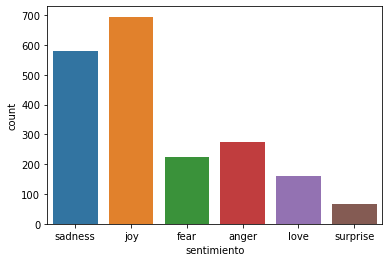

In [316]:
# print(len(X_vec.toarray()), df["sentimiento"].count())
ax = sns.countplot(x='sentimiento', data=df)

Como se puede ver, existe un desbalanceo notable. La mayoría de registros se concentran en las emociones "sadness" y "joy".

Intentaremos arreglar este problema de desbalanceo con la técnica de SMOTE

In [317]:
# sm = SMOTE(random_state=0)

# X_sm, y_sm = sm.fit_resample(X_vec,y)

In [318]:
# print(f'''Shape of X before SMOTE: {X_vec.shape}
# Hape of X after SMOTE: {X_sm.shape}\n''')
# ax = sns.countplot(x='sentimiento', data=pd.DataFrame(y_sm, columns=['sentimiento']))

### Búsqueda de hiperparámetros

In [319]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,8,12,20,24],'min_samples_split':range(2,10)}

# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

In [320]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(tfidf_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 12, 20, 24],
                         'min_samples_split': range(2, 10)})

In [321]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 24, 'min_samples_split': 2}

In [322]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
arbol_final = arbol_final.fit(tfidf_train,y_train)

Vemos el desempeño sobre el conjunto de entrenamiento:

In [323]:
# arbol_final = DecisionTreeClassifier(criterion="gini", max_depth=12, min_samples_split=2)
# arbol_final = arbol_final.fit(tfidf_train,y_train)

In [324]:
y_pred = arbol_final.predict(tfidf_train)
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred))
print("Recall: {}".format(recall_score(y_train,y_pred, average="weighted")))
print("Precisión: {}".format(precision_score(y_train,y_pred, average="weighted")))
print("Puntuación F1: {}".format(f1_score(y_train,y_pred, average="weighted")))

Exactitud: 0.60
Recall: 0.6016666666666667
Precisión: 0.6903132678132679
Puntuación F1: 0.5989606351469928


Vemos el desempeño sobre el conjunto de prueba:

In [325]:
y_pred = arbol_final.predict(tfidf_test)
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred,average="weighted")))
print("Precisión: {}".format(precision_score(y_test,y_pred,average="weighted")))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred,average="weighted")))

Exactitud: 0.38
Recall: 0.375
Precisión: 0.49133407277755614
Puntuación F1: 0.35103351013797174


## Random Forest (test)

In [340]:
r_forest = RandomForestClassifier()
r_forest.fit(tfidf_train,y_train)

RandomForestClassifier()

Resultados preliminares

In [341]:
y_pred = rf_final.predict(tfidf_train)
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred))
print("Recall: {}".format(recall_score(y_train,y_pred, average="weighted")))
print("Precisión: {}".format(precision_score(y_train,y_pred, average="weighted")))
print("Puntuación F1: {}".format(f1_score(y_train,y_pred, average="weighted")))

Exactitud: 0.53
Recall: 0.5283333333333333
Precisión: 0.7585315139701104
Puntuación F1: 0.4661283452502253


### Búsqueda de hiperparámetros

In [334]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,8,12,20,24],'min_samples_split':range(2,10)}

# Definimos el modelo sin ningún valor de estos hiperparámetros
r_forest = RandomForestClassifier()

In [335]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(r_forest, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(tfidf_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 8, 12, 20, 24],
                         'min_samples_split': range(2, 10)})

In [336]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 6}

In [337]:
# Obtener el mejor modelo.
rf_final = mejor_modelo.best_estimator_
rf_final = rf_final.fit(tfidf_train,y_train)

In [338]:
y_pred = rf_final.predict(tfidf_train)
print('Exactitud: %.2f' % accuracy_score(y_train, y_pred))
print("Recall: {}".format(recall_score(y_train,y_pred, average="weighted")))
print("Precisión: {}".format(precision_score(y_train,y_pred, average="weighted")))
print("Puntuación F1: {}".format(f1_score(y_train,y_pred, average="weighted")))

Exactitud: 0.53
Recall: 0.5283333333333333
Precisión: 0.7585315139701104
Puntuación F1: 0.4661283452502253


Vemos el desempeño sobre el conjunto de prueba:

In [339]:
y_pred = rf_final.predict(tfidf_test)
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred,average="weighted")))
print("Precisión: {}".format(precision_score(y_test,y_pred,average="weighted")))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred,average="weighted")))

Exactitud: 0.36
Recall: 0.36
Precisión: 0.6821733632790897
Puntuación F1: 0.22549545303885338
